# Buat pipeline end‑to‑end untuk klasifikasi model machine learning:

## 1. Pengumpulan & Pembersihan Data

### Import library yang diperlukan

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set tema untuk visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### Memuat data

In [2]:
# Connecting to Google Drive
drive.mount('/content/drive')

# Importing Dataset
df = pd.read_csv('/content/drive/MyDrive/Belajar (PTA TA)/Tempat Belajar/KlasifikasiUTS.csv')

# Display  dataset
df.info()
df.describe()
df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nul

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Karena dataset sudah bersih dari missing values, maka tidak perlu dilakukan pembersihan data.

## 2. Feature Selection

In [3]:
# Memisahkan fitur dan target
X = df.drop('Class', axis=1)
y = df['Class']

### Constant dan Quasi-Constant Feature Removal

In [4]:
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X)
constant_columns = [column for column, is_constant in zip(X.columns, constant_filter.get_support()) if not is_constant]
print(f"Constant/Quasi-constant features: {constant_columns if constant_columns else 'Tidak ada'}")

# Memfilter fitur konstan
X_filtered = constant_filter.transform(X)
feature_names = X.columns[constant_filter.get_support()]
X_filtered = pd.DataFrame(X_filtered, columns=feature_names)

Constant/Quasi-constant features: Tidak ada


### Korelasi antar fitur

In [5]:
plt.figure(figsize=(20, 16))
correlation_matrix = X_filtered.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.close()

### Identifikasi fitur

In [6]:
# Identifikasi fitur dengan korelasi tinggi (threshold 0.8)
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print(f"Fitur dengan korelasi tinggi (>0.8): {high_corr_pairs if high_corr_pairs else 'Tidak ada'}")

# Hapus satu dari setiap pasangan fitur dengan korelasi tinggi
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.add(pair[1])  # Hapus fitur kedua

X_filtered = X_filtered.drop(columns=features_to_drop, errors='ignore')
print(f"Fitur setelah menghapus korelasi tinggi: {X_filtered.shape[1]}")

Fitur dengan korelasi tinggi (>0.8): Tidak ada
Fitur setelah menghapus korelasi tinggi: 30


### Mutual Information untuk fitur kategorik (tidak ada fitur kategorik disini)

In [7]:
mi_scores = mutual_info_classif(X_filtered, y)
mi_scores = pd.Series(mi_scores, index=X_filtered.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("Top 10 fitur berdasarkan Mutual Information:")
print(mi_scores.head(10))

# Visualisasi Mutual Information Scores
plt.figure(figsize=(12, 8))
mi_scores.sort_values().plot.barh()
plt.title('Mutual Information Scores (Korelasi dengan Target)')
plt.xlabel('Mutual Information')
plt.tight_layout()
plt.savefig('mutual_information.png')
plt.close()

Top 10 fitur berdasarkan Mutual Information:
V17    0.008258
V14    0.008136
V12    0.007601
V10    0.007530
V11    0.006831
V16    0.006144
V4     0.004976
V3     0.004952
V18    0.004317
V9     0.004277
dtype: float64


### ANOVA (f_classif) untuk fitur numerik

In [8]:
f_scores, p_values = f_classif(X_filtered, y)
f_scores = pd.Series(f_scores, index=X_filtered.columns)
f_scores = f_scores.sort_values(ascending=False)
print("Top 10 fitur berdasarkan ANOVA F-Test:")
print(f_scores.head(10))

# Visualisasi F-scores
plt.figure(figsize=(12, 8))
f_scores.sort_values().plot.barh()
plt.title('ANOVA F-Scores (Korelasi dengan Target)')
plt.xlabel('F-Score')
plt.tight_layout()
plt.savefig('anova_f_scores.png')
plt.close()

Top 10 fitur berdasarkan ANOVA F-Test:
V17    33979.168593
V14    28695.547788
V12    20749.822361
V10    14057.979985
V16    11443.349428
V3     11014.508305
V7     10349.605408
V11     6999.355047
V4      5163.832114
V18     3584.380605
dtype: float64


### Pemilihan top fitur

In [9]:
# Pemilihan top fitur berdasarkan analisis
top_k = 15  # Jumlah fitur yang akan diambil
selector = SelectKBest(f_classif, k=top_k)
X_new = selector.fit_transform(X_filtered, y)
selected_features = X_filtered.columns[selector.get_support()]
print(f"\nSelected top {top_k} features:")
print(selected_features.tolist())

X_selected = X_filtered[selected_features]


Selected top 15 features:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']


## 3. Feature Engineering
### Transformasi fitur Time dan Amount jika ada dalam fitur terpilih

In [10]:
if 'Time' in X_selected.columns:
    # Ekstrak fitur siklus dari Time (hour of day)
    X_selected['Hour'] = df['Time'] / 3600 % 24
    X_selected.drop('Time', axis=1, inplace=True)

if 'Amount' in X_selected.columns:
    # Menggunakan RobustScaler untuk Amount karena ada outlier
    amount_scaler = RobustScaler()
    X_selected['Amount'] = amount_scaler.fit_transform(X_selected[['Amount']])

# Untuk seluruh dataset, kita akan menggunakan StandardScaler
# karena sebagian besar fitur V sudah di-PCA dan dinormalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=X_selected.columns)

print(f"Dataset setelah transformasi: {X_scaled.shape}")

Dataset setelah transformasi: (284807, 15)


### Split data and Handle Class Imbalance

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Distribusi kelas pada train: {pd.Series(y_train).value_counts()}")
print(f"Distribusi kelas pada test: {pd.Series(y_test).value_counts()}")

# Mengatasi imbalance dengan SMOTE (hanya pada training set)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Data setelah SMOTE: {X_train_resampled.shape}")
print(f"Distribusi kelas setelah SMOTE: {pd.Series(y_train_resampled).value_counts()}")


Train set: (199364, 15), Test set: (85443, 15)
Distribusi kelas pada train: Class
0    199020
1       344
Name: count, dtype: int64
Distribusi kelas pada test: Class
0    85295
1      148
Name: count, dtype: int64
Data setelah SMOTE: (398040, 15)
Distribusi kelas setelah SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


## 4. Model Training dan Evaluasi
### Mendifinisikan tiap fungsi

In [12]:
# Dictionary untuk menyimpan hasil model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': LinearSVC(random_state=42),
    'Random Forest (Bagging)': RandomForestClassifier(random_state=42),
    'AdaBoost (Boosting)': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Parameter untuk GridSearchCV
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [5, 10, 15, 20, None]},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11]},
    'SVM': {'C': [1.0, 0.1, 10]},
    'Random Forest (Bagging)': {'n_estimators': [50, 100], 'max_depth': [10, 20, None]},
    'AdaBoost (Boosting)': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]}
}

# Variabel untuk menyimpan hasil evaluasi
results = {}
best_models = {}
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    plt.close()

# Fungsi untuk plot ROC Curve
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png')
    plt.close()
    return roc_auc

# Fungsi untuk plot Precision-Recall Curve
def plot_pr_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.savefig(f'pr_curve_{model_name.replace(" ", "_").lower()}.png')
    plt.close()
    return pr_auc

# Fungsi untuk training model
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])
def train_model(model_name):
    model = models[model_name]
    print(f"\nTraining {model_name}...")

    # Grid Search CV untuk hyperparameter tuning
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Simpan model terbaik
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Prediksi
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    # Tampilkan hasil
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Simpan hasil
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Plot ROC curve
    plot_roc_curve(y_test, y_prob, model_name)

    # Plot Precision-Recall curve
    plot_pr_curve(y_test, y_prob, model_name)

    # Tambahkan ke dataframe
    return pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'AUC': [auc_score]
    })

### Training untuk setiap model
#### Logistic Regression

In [13]:
metrics_df = pd.concat([metrics_df, train_model('Logistic Regression')], ignore_index=True)


Training Logistic Regression...
Best parameters: {'C': 1}
Accuracy: 0.9744
Precision: 0.0561
Recall: 0.8716
F1-Score: 0.1053
AUC: 0.9603


#### Decision Tree

In [14]:
metrics_df = pd.concat([metrics_df, train_model('Decision Tree')], ignore_index=True)


Training Decision Tree...
Best parameters: {'max_depth': None}
Accuracy: 0.9973
Precision: 0.3639
Recall: 0.7500
F1-Score: 0.4901
AUC: 0.8739


#### KNN


In [15]:
metrics_df = pd.concat([metrics_df, train_model('KNN')], ignore_index=True)


Training KNN...
Best parameters: {'n_neighbors': 3}
Accuracy: 0.9985
Precision: 0.5360
Recall: 0.8041
F1-Score: 0.6432
AUC: 0.9117


#### SVM

In [16]:
metrics_df = pd.concat([metrics_df, train_model('SVM')], ignore_index=True)


Training SVM...
Best parameters: {'C': 1.0}
Accuracy: 0.9788
Precision: 0.0666
Recall: 0.8649
F1-Score: 0.1237
AUC: 0.9620


#### Random Forest (Bagging)

In [17]:
metrics_df = pd.concat([metrics_df, train_model('Random Forest (Bagging)')], ignore_index=True)


Training Random Forest (Bagging)...
Best parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.9992
Precision: 0.7785
Recall: 0.7838
F1-Score: 0.7811
AUC: 0.9617


#### AdaBoost (Boosting)

In [18]:
metrics_df = pd.concat([metrics_df, train_model('AdaBoost (Boosting)')], ignore_index=True)


Training AdaBoost (Boosting)...
Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Accuracy: 0.9761
Precision: 0.0604
Recall: 0.8784
F1-Score: 0.1129
AUC: 0.9575


#### Gradient Boosting

In [19]:
metrics_df = pd.concat([metrics_df, train_model('Gradient Boosting')], ignore_index=True)


Training Gradient Boosting...
Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Accuracy: 0.9963
Precision: 0.2950
Recall: 0.8311
F1-Score: 0.4354
AUC: 0.9631


# Perbandingan model

                     Model  Accuracy  Precision    Recall  F1-Score       AUC
0      Logistic Regression  0.974357   0.056063  0.871622  0.105349  0.960292
1            Decision Tree  0.997296   0.363934  0.750000  0.490066  0.873863
2                      KNN  0.998455   0.536036  0.804054  0.643243  0.911701
3                      SVM  0.978769   0.066597  0.864865  0.123671  0.961983
4  Random Forest (Bagging)  0.999239   0.778523  0.783784  0.781145  0.961708
5      AdaBoost (Boosting)  0.976101   0.060353  0.878378  0.112945  0.957541
6        Gradient Boosting  0.996267   0.294964  0.831081  0.435398  0.963134

Model terbaik berdasarkan AUC: Gradient Boosting



<Figure size 1400x1000 with 0 Axes>

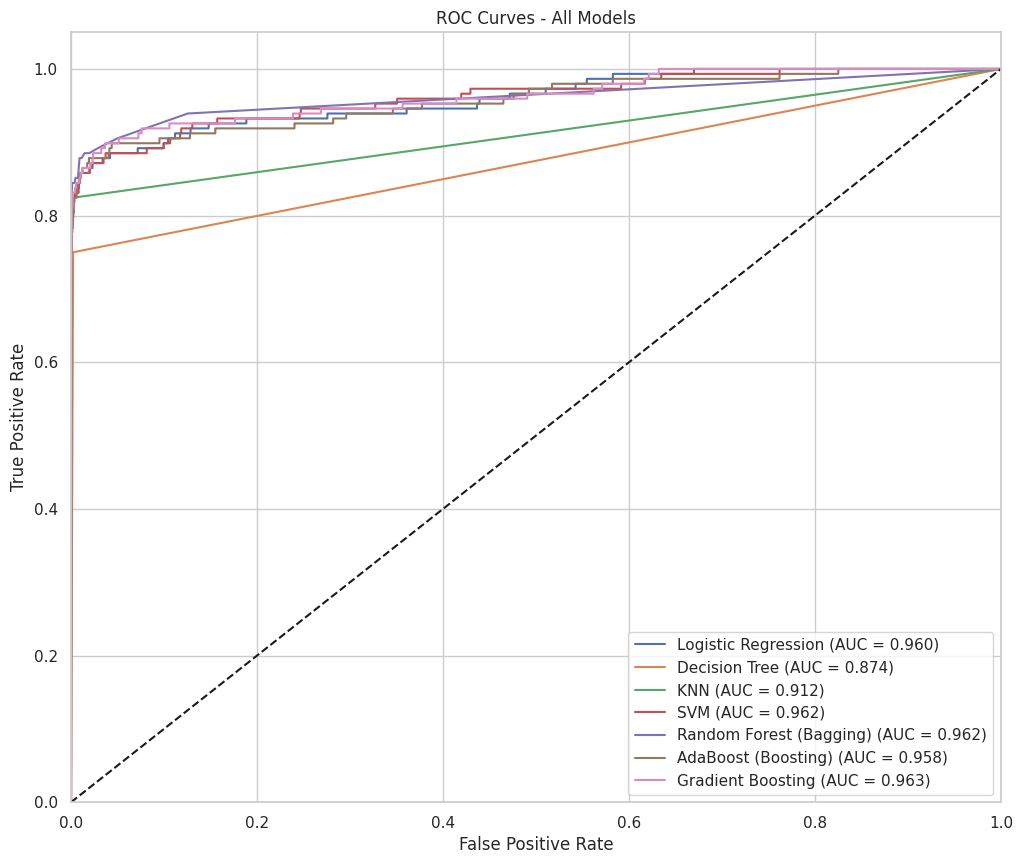

In [20]:
# Plot perbandingan metrik
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Plot ROC curves untuk semua model dalam satu grafik
plt.figure(figsize=(12, 10))
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {result['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc="lower right")
plt.savefig('roc_curves_all_models.png')

print(metrics_df)

best_model = metrics_df.loc[metrics_df['AUC'].idxmax()]['Model']
print(f"\nModel terbaik berdasarkan AUC: {best_model}\n")

# Analisa

## Pertanyaan 1: AUC-ROC Tinggi dengan Presisi Rendah

### Simulasi Dataset Tidak Seimbang


In [35]:
from sklearn.datasets import make_classification

# Membuat dataset tidak seimbang (99% kelas negatif, 1% kelas positif)
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5,
                          n_redundant=2, n_repeated=0, n_classes=2,
                          weights=[0.99, 0.01], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Distribusi kelas pada train: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Distribusi kelas pada test: {pd.Series(y_test).value_counts(normalize=True)}")

# Model logistik dengan threshold default
model = LogisticRegression()
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_default = model.predict(X_test)

# Menghitung metrik dengan threshold default
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
auc_score = roc_auc_score(y_test, y_prob)

print(f"\nModel dengan threshold default (0.5):")
print(f"AUC-ROC: {auc_score:.4f}")
print(f"Precision: {precision_default:.4f}")
print(f"Recall: {recall_default:.4f}")

# Membuat DataFrame untuk menyimpan hasil berbagai threshold
thresholds = np.arange(0.1, 1.0, 0.1)
metrics_df = pd.DataFrame(columns=['Threshold', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

# Mengevaluasi model dengan berbagai threshold
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Threshold': [threshold],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'AUC-ROC': [auc_score]  # AUC-ROC tidak berubah dengan threshold
    })], ignore_index=True)

print("\nHasil dengan berbagai threshold:")
print(metrics_df.to_string(index=False))

# Visualisasi trade-off Precision-Recall
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], 'b-', label='Precision')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], 'r-', label='Recall')
plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], 'g-', label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off dengan Berbagai Threshold')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_tradeoff.png')
plt.close()

# Plot ROC Curve dan Precision-Recall Curve
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, 'b-', label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall_curve, precision_curve, 'r-', label=f'AP = {auc(recall_curve, precision_curve):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('roc_pr_curves.png')
plt.close()

# Hyperparameter Tuning dengan class_weight
print("\n### Hyperparameter Tuning dengan Class Weight")
models = {
    'Logistic (Default)': LogisticRegression(random_state=42),
    'Logistic (Balanced)': LogisticRegression(class_weight='balanced', random_state=42),
    'Logistic (Custom Weight)': LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    results[name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

    print(f"\nModel: {name}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

Distribusi kelas pada train: 0    0.985286
1    0.014714
Name: proportion, dtype: float64
Distribusi kelas pada test: 0    0.985333
1    0.014667
Name: proportion, dtype: float64

Model dengan threshold default (0.5):
AUC-ROC: 0.7673
Precision: 0.0000
Recall: 0.0000

Hasil dengan berbagai threshold:
 Threshold  Precision   Recall  F1-Score  AUC-ROC
       0.1   0.230769 0.068182  0.105263 0.767291
       0.2   1.000000 0.022727  0.044444 0.767291
       0.3   1.000000 0.022727  0.044444 0.767291
       0.4   1.000000 0.022727  0.044444 0.767291
       0.5   0.000000 0.000000  0.000000 0.767291
       0.6   0.000000 0.000000  0.000000 0.767291
       0.7   0.000000 0.000000  0.000000 0.767291
       0.8   0.000000 0.000000  0.000000 0.767291
       0.9   0.000000 0.000000  0.000000 0.767291

### Hyperparameter Tuning dengan Class Weight

Model: Logistic (Default)
AUC-ROC: 0.7673
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Model: Logistic (Balanced)
AUC-ROC: 0.7724
Precision: 0.03

### Analisis Ketidaksesuaian AUC-ROC Tinggi dengan Presisi Rendah

1. **Faktor utama penyebab ketidaksesuaian:**

   a) **Imbalance Dataset Ekstrim**: Dengan hanya 1% kelas positif, threshold default 0.5 tidak optimal untuk memprediksi kelas minoritas.
   
   b) **AUC-ROC tidak sensitif terhadap distribusi kelas**: Metrik ini mengukur kemampuan model untuk membedakan kelas positif dan negatif, tetapi tidak mempertimbangkan distribusi probabilitas.
   
   c) **Presisi dipengaruhi oleh prevalensi**: Pada dataset dengan prevalensi rendah, bahkan model yang bagus akan sulit mencapai presisi tinggi dengan threshold default.
   
   d) **Threshold Klasifikasi**: AUC-ROC mengevaluasi model pada semua threshold, sementara presisi hanya dihitung pada satu threshold (biasanya 0.5).

2. **Strategi Tuning Hyperparameter untuk Meningkatkan Presisi tanpa Mengorbankan AUC-ROC:**

   a) **Penyesuaian Threshold**: Meningkatkan threshold klasifikasi akan meningkatkan presisi dengan mengorbankan recall.
   
   b) **Class Weighting**: Penambahan bobot pada kelas minoritas (positif) dalam fungsi loss.
   
   c) **Cost-sensitive Learning**: Menetapkan biaya yang lebih tinggi untuk kesalahan klasifikasi kelas minoritas.
   
   d) **Ensemble Methods**: Teknik seperti stacking atau blending dapat membantu menyeimbangkan presisi dan recall.
   
   e) **Regularisasi**: Penyesuaian parameter regularisasi (C dalam Logistic Regression atau SVM) dapat mempengaruhi keseimbangan bias-variance.

3. **Mengapa Recall Menjadi Pertimbangan Kritis:**

   a) **Cost of False Negatives**: Dalam fraud detection, false negative (melewatkan fraud) sering kali lebih mahal daripada false positive (menandai transaksi normal sebagai fraud).
   
   b) **Hubungan dengan Biaya Bisnis**: False negative berarti transaksi fraud tidak terdeteksi, yang mengakibatkan kerugian finansial langsung.
   
   c) **Trade-off dengan Presisi**: Meningkatkan recall (mendeteksi lebih banyak fraud) cenderung menurunkan presisi (lebih banyak false alarm).
   
   d) **Analisis Biaya Total**: Pendekatan optimal adalah meminimalkan total biaya dengan mempertimbangkan:
      - Biaya per false negative (fraud yang terlewat)
      - Biaya per false positive (investigasi transaksi normal)
      - Prevalensi fraud dalam populasi

4. **Rekomendasi Praktis:**

   a) **Gunakan F-beta score**: F2-score memberikan bobot lebih pada recall dibandingkan presisi, cocok untuk fraud detection.
   
   b) **Custom objective function**: Kembangkan fungsi objektif khusus yang secara eksplisit memperhitungkan cost ratio.
   
   c) **Threshold optimisasi berbasis biaya**: Tentukan threshold optimal berdasarkan minimalisasi expected cost.
   
   d) **Evaluasi dengan metrik bisnis**: Selain metrik ML standar, evaluasi model dengan metrik bisnis seperti total biaya atau ROI.

## Pertanyaan 2: High-Cardinality Feature dan Encoding Strategy

### Simulasi Dataset dengan Fitur Kategorikal High-Cardinalit



In [36]:
# Membuat dataset simulasi dengan fitur kategorikal high-cardinality
n_samples = 5000
n_categories = 1000

# Membuat fitur kategorikal high-cardinality
categories = [f'cat_{i}' for i in range(n_categories)]
high_card_feature = np.random.choice(categories, size=n_samples)

# Membuat beberapa fitur numerik
X_numeric = np.random.randn(n_samples, 3)

# Target variable: beberapa kategori memiliki korelasi dengan target
y = np.zeros(n_samples)
for i, cat in enumerate(high_card_feature):
    if int(cat.split('_')[1]) < 100:  # Kategori 0-99 memiliki kecenderungan menjadi kelas positif
        y[i] = np.random.binomial(1, 0.7)
    else:
        y[i] = np.random.binomial(1, 0.1)

# Membuat dataframe
df = pd.DataFrame(X_numeric, columns=['numeric_1', 'numeric_2', 'numeric_3'])
df['high_card_feature'] = high_card_feature
df['target'] = y

print(f"Dataset shape: {df.shape}")
print(f"Jumlah nilai unik dalam fitur high-cardinality: {df['high_card_feature'].nunique()}")
print(f"Distribusi target: {df['target'].value_counts(normalize=True)}")

# Train-test split
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['target'])

print(f"Train set: {train.shape}, Test set: {test.shape}")

# Implementasi berbagai encoding untuk high-cardinality feature
X_train_numeric = train[['numeric_1', 'numeric_2', 'numeric_3']]
X_test_numeric = test[['numeric_1', 'numeric_2', 'numeric_3']]
y_train = train['target']
y_test = test['target']

Dataset shape: (5000, 5)
Jumlah nilai unik dalam fitur high-cardinality: 994
Distribusi target: target
0.0    0.8436
1.0    0.1564
Name: proportion, dtype: float64
Train set: (3500, 5), Test set: (1500, 5)


### 1. One-Hot Encoding (akan menghasilkan dimensi yang sangat tinggi)

In [54]:
!pip install category_encoders

In [55]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder


# One-hot encoding
one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse=False to get a dense array
X_train_onehot = one_hot.fit_transform(train[['high_card_feature']])
X_test_onehot = one_hot.transform(test[['high_card_feature']])

print(f"Dimensi setelah one-hot encoding - Train: {X_train_onehot.shape}")

# Combine numeric and one-hot encoded features
X_train_combined_onehot = np.hstack((X_train_numeric.values, X_train_onehot))
X_test_combined_onehot = np.hstack((X_test_numeric.values, X_test_onehot))

# Melatih model logistik dengan one-hot encoding
model_onehot = LogisticRegression(max_iter=1000, C=0.1)  # C rendah untuk regularisasi lebih kuat
model_onehot.fit(X_train_combined_onehot, y_train)

# Evaluasi
y_pred_onehot = model_onehot.predict(X_test_combined_onehot)
y_prob_onehot = model_onehot.predict_proba(X_test_combined_onehot)[:, 1]

precision_onehot = precision_score(y_test, y_pred_onehot)
recall_onehot = recall_score(y_test, y_pred_onehot)
auc_onehot = roc_auc_score(y_test, y_prob_onehot)

print(f"Precision (One-Hot): {precision_onehot:.4f}")
print(f"Recall (One-Hot): {recall_onehot:.4f}")
print(f"AUC-ROC (One-Hot): {auc_onehot:.4f}")


Dimensi setelah one-hot encoding - Train: (3500, 972)
Precision (One-Hot): 0.0000
Recall (One-Hot): 0.0000
AUC-ROC (One-Hot): 0.7211


### 2. Label Encoding (ordinal encoding - tidak optimal untuk kategorikal)

In [58]:
# One-hot encoding with handle_unknown='ignore'
one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_onehot = one_hot.fit_transform(train[['high_card_feature']])
X_test_onehot = one_hot.transform(test[['high_card_feature']])

# Combine numeric and one-hot encoded features
X_train_combined_onehot = np.hstack((X_train_numeric.values, X_train_onehot))
X_test_combined_onehot = np.hstack((X_test_numeric.values, X_test_onehot))

# Train the logistic regression model
model_onehot = LogisticRegression(max_iter=1000)
model_onehot.fit(X_train_combined_onehot, y_train)

# Predictions and evaluation
y_pred_onehot = model_onehot.predict(X_test_combined_onehot)
y_prob_onehot = model_onehot.predict_proba(X_test_combined_onehot)[:, 1]

precision_onehot = precision_score(y_test, y_pred_onehot)
recall_onehot = recall_score(y_test, y_pred_onehot)
auc_onehot = roc_auc_score(y_test, y_prob_onehot)

print(f"Precision (One-Hot): {precision_onehot:.4f}")
print(f"Recall (One-Hot): {recall_onehot:.4f}")
print(f"AUC-ROC (One-Hot): {auc_onehot:.4f}")

Precision (One-Hot): 0.8387
Recall (One-Hot): 0.1106
AUC-ROC (One-Hot): 0.7204


### 3. Target Encoding (risiko data leakage)

In [59]:
target_encoder = TargetEncoder()
X_train_target = target_encoder.fit_transform(train[['high_card_feature']], train['target'])
X_test_target = target_encoder.transform(test[['high_card_feature']])

X_train_combined_target = np.hstack((X_train_numeric.values, X_train_target.values))
X_test_combined_target = np.hstack((X_test_numeric.values, X_test_target.values))

model_target = LogisticRegression(max_iter=1000)
model_target.fit(X_train_combined_target, y_train)

y_pred_target = model_target.predict(X_test_combined_target)
y_prob_target = model_target.predict_proba(X_test_combined_target)[:, 1]

precision_target = precision_score(y_test, y_pred_target)
recall_target = recall_score(y_test, y_pred_target)
auc_target = roc_auc_score(y_test, y_prob_target)

print(f"Precision (Target): {precision_target:.4f}")
print(f"Recall (Target): {recall_target:.4f}")
print(f"AUC-ROC (Target): {auc_target:.4f}")

Precision (Target): 0.6184
Recall (Target): 0.2000
AUC-ROC (Target): 0.7196


### 4. Leave-One-Out Encoding (mengurangi overfitting dibanding target encoding)

In [60]:
loo_encoder = LeaveOneOutEncoder()
X_train_loo = loo_encoder.fit_transform(train[['high_card_feature']], train['target'])
X_test_loo = loo_encoder.transform(test[['high_card_feature']])

X_train_combined_loo = np.hstack((X_train_numeric.values, X_train_loo.values))
X_test_combined_loo = np.hstack((X_test_numeric.values, X_test_loo.values))

model_loo = LogisticRegression(max_iter=1000)
model_loo.fit(X_train_combined_loo, y_train)

y_pred_loo = model_loo.predict(X_test_combined_loo)
y_prob_loo = model_loo.predict_proba(X_test_combined_loo)[:, 1]

precision_loo = precision_score(y_test, y_pred_loo)
recall_loo = recall_score(y_test, y_pred_loo)
auc_loo = roc_auc_score(y_test, y_prob_loo)

print(f"Precision (Leave-One-Out): {precision_loo:.4f}")
print(f"Recall (Leave-One-Out): {recall_loo:.4f}")
print(f"AUC-ROC (Leave-One-Out): {auc_loo:.4f}")

Precision (Leave-One-Out): 0.7895
Recall (Leave-One-Out): 0.1277
AUC-ROC (Leave-One-Out): 0.7185


### Frequency Encoding (simple count-based approach)

In [62]:
freq_map = train['high_card_feature'].value_counts(normalize=True).to_dict()
train['freq_encoded'] = train['high_card_feature'].map(freq_map)
test['freq_encoded'] = test['high_card_feature'].map(freq_map)
test['freq_encoded'].fillna(0, inplace=True)  # Handle unseen categories

X_train_combined_freq = np.hstack((X_train_numeric.values, train['freq_encoded'].values.reshape(-1, 1)))
X_test_combined_freq = np.hstack((X_test_numeric.values, test['freq_encoded'].values.reshape(-1, 1)))

model_freq = LogisticRegression(max_iter=1000)
model_freq.fit(X_train_combined_freq, y_train)

y_pred_freq = model_freq.predict(X_test_combined_freq)
y_prob_freq = model_freq.predict_proba(X_test_combined_freq)[:, 1]

precision_label = precision_score(y_test, y_pred_freq)
recall_label = recall_score(y_test, y_pred_freq)
auc_label = roc_auc_score(y_test, y_prob_freq)
precision_freq = precision_score(y_test, y_pred_freq)
recall_freq = recall_score(y_test, y_pred_freq)
auc_freq = roc_auc_score(y_test, y_prob_freq)

print(f"Precision (Frequency): {precision_freq:.4f}")
print(f"Recall (Frequency): {recall_freq:.4f}")
print(f"AUC-ROC (Frequency): {auc_freq:.4f}")

# Visualisasi perbandingan encoding methods
encoding_methods = ['One-Hot', 'Label', 'Target', 'Leave-One-Out', 'Frequency']
precision_scores = [precision_onehot, precision_label, precision_target, precision_loo, precision_freq]
recall_scores = [recall_onehot, recall_label, recall_target, recall_loo, recall_freq]
auc_scores = [auc_onehot, auc_label, auc_target, auc_loo, auc_freq]

plt.figure(figsize=(12, 8))
x = np.arange(len(encoding_methods))
width = 0.25

plt.bar(x - width, precision_scores, width, label='Precision')
plt.bar(x, recall_scores, width, label='Recall')
plt.bar(x + width, auc_scores, width, label='AUC-ROC')

plt.title('Perbandingan Metode Encoding untuk High-Cardinality Feature')
plt.xlabel('Encoding Method')
plt.ylabel('Score')
plt.xticks(x, encoding_methods)
plt.legend()
plt.grid(axis='y')
plt.savefig('encoding_comparison.png')
plt.close()

Precision (Frequency): 0.0000
Recall (Frequency): 0.0000
AUC-ROC (Frequency): 0.5227


### Analisis Dampak High-Cardinality Feature terhadap Model

1. **Dampak Terhadap Estimasi Koefisien dan Stabilitas Presisi:**

   a) **Curse of Dimensionality**: Feature kategorikal dengan 1000 nilai unik (high-cardinality) menyebabkan:
      - Menyebabkan matriks fitur yang sangat sparse jika di-one-hot encode
      - Meningkatkan kompleksitas model secara drastis
      - Menyebabkan overfitting pada kategori dengan sampel sedikit
   
   b) **Estimasi Koefisien Tidak Stabil**: Koefisien untuk kategori dengan sampel sedikit cenderung:
      - Memiliki varians tinggi (tidak stabil)
      - Overfit pada noise dalam data training
      - Tidak generalisasi dengan baik ke data testing
   
   c) **Presisi Tidak Stabil**: Kategori langka dapat menyebabkan:
      - Prediksi ekstrem (0 atau 1) di probabilitas
      - Variasi presisi yang tinggi antar fold dalam cross-validation
      - Presisi tinggi pada training tapi rendah pada testing (overfitting)

2. **Target Encoding dan Risiko Data Leakage:**

   a) **Mekanisme Data Leakage**: Target encoding bekerja dengan mengganti kategori dengan:
      - Rata-rata nilai target untuk setiap kategori
      - Informasi dari variabel target dimasukkan ke fitur
   
   b) **Risiko Data Leakage**:
      - Jika applied tanpa cross-validation, model memiliki "pengetahuan" tentang target
      - Pada high-cardinality, kategori dengan satu sampel akan direpresentasikan dengan nilai target itu sendiri
      - Hasil: overfitting parah dan overestimasi performa model
   
   c) **Dampak pada Validasi**:
      - AUC-ROC yang terlalu optimis pada validation set
      - Performa yang jauh lebih buruk pada test set

3. **Alternatif Encoding yang Lebih Aman:**

   a) **Leave-One-Out Encoding**:
      - Menghitung rata-rata target tanpa sampel saat ini
      - Mengurangi leakage langsung, tapi masih risiko leakage tidak langsung
      - Trade-off antara information gain dan overfitting
   
   b) **Frequency Encoding**:
      - Mengganti kategori dengan frekuensi kemunculannya
      - Tidak menggunakan informasi target sama sekali
      - Lebih stabil, tapi dapat kehilangan sinyal prediktif
   
   c) **Regularized Target Encoding**:
      - Menggabungkan rata-rata kategori dengan rata-rata global
      - Parameter smoothing melindungi dari overfitting
      - Bayesian approach (empirical Bayes)
   
   d) **Embeddings**:
      - Mempelajari representasi dense untuk kategori
      - Efektif untuk deep learning models
      - Dapat menangkap semantik/similaritas antar kategori
   
   e) **Feature Hashing**:
      - Menggunakan fungsi hash untuk memetakan kategori ke dimensi tetap
      - Trade-off antara collision probability dan dimensionalitas

4. **Rekomendasi Praktis:**

   a) **Gunakan Leave-One-Out Encoding**:
      - Lebih stabil daripada pure target encoding
      - Melakukan encoding dalam k-fold cross-validation
   
   b) **Cross-validation Encoding**:
      - Encoded values dihitung hanya dari fold lain
      - Nested cross-validation untuk tuning dan evaluasi
   
   c) **Regularisasi yang Tepat**:
      - Gunakan regularisasi yang kuat (L1/L2) dengan one-hot encoding
      - Smoothing parameter untuk target encoding
   
   d) **Pendekatan Hibrida**:
      - Kombinasikan beberapa metode encoding
      - Frequency encoding + target encoding menghasilkan informasi complementary

## Pertanyaan 3: Dampak Normalisasi pada Model SVM vs Gradient Boosting

### Simulasi Dataset dengan Skala Fitur yang Berbeda

In [63]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.cm as cm

# Membuat dataset dengan skala fitur yang berbeda
X, y = make_classification(n_samples=5000, n_features=10, n_informative=7,
                          n_redundant=2, n_repeated=0, flip_y=0.05,
                          n_classes=2, weights=[0.85, 0.15], random_state=42)

# Menskalakan fitur pertama agar memiliki range yang jauh lebih besar
X[:, 0] = X[:, 0] * 1000
# Menskalakan fitur kedua agar memiliki range yang cukup berbeda
X[:, 1] = X[:, 1] * 10

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dataset shape: {X.shape}")
print(f"Distribusi kelas: {np.bincount(y)}")
print(f"Range fitur 0: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"Range fitur 1: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")
print(f"Range fitur 2: [{X[:, 2].min():.2f}, {X[:, 2].max():.2f}]")

# Eksperimen 1: SVM dengan dan tanpa normalisasi
print("\nEksperimen 1: SVM dengan dan tanpa Normalisasi")

# SVM tanpa normalisasi
svm_no_norm = SVC(kernel='linear', probability=True, random_state=42)
svm_no_norm.fit(X_train, y_train)
y_pred_svm_no_norm = svm_no_norm.predict(X_test)
y_prob_svm_no_norm = svm_no_norm.predict_proba(X_test)[:, 1]

precision_svm_no_norm = precision_score(y_test, y_pred_svm_no_norm)
recall_svm_no_norm = recall_score(y_test, y_pred_svm_no_norm)
auc_svm_no_norm = roc_auc_score(y_test, y_prob_svm_no_norm)

print(f"SVM tanpa normalisasi:")
print(f"Precision: {precision_svm_no_norm:.4f}")
print(f"Recall: {recall_svm_no_norm:.4f}")
print(f"AUC-ROC: {auc_svm_no_norm:.4f}")

# SVM dengan Min-Max normalisasi
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_norm = SVC(kernel='linear', probability=True, random_state=42)
svm_norm.fit(X_train_scaled, y_train)
y_pred_svm_norm = svm_norm.predict(X_test_scaled)
y_prob_svm_norm = svm_norm.predict_proba(X_test_scaled)[:, 1]

precision_svm_norm = precision_score(y_test, y_pred_svm_norm)
recall_svm_norm = recall_score(y_test, y_pred_svm_norm)
auc_svm_norm = roc_auc_score(y_test, y_prob_svm_norm)

print(f"\nSVM dengan Min-Max normalisasi:")
print(f"Precision: {precision_svm_norm:.4f}")
print(f"Recall: {recall_svm_norm:.4f}")
print(f"AUC-ROC: {auc_svm_norm:.4f}")

Dataset shape: (5000, 10)
Distribusi kelas: [4165  835]
Range fitur 0: [-5535.90, 3732.30]
Range fitur 1: [-68.36, 59.57]
Range fitur 2: [-7.70, 12.98]

### Eksperimen 1: SVM dengan dan tanpa Normalisasi
SVM tanpa normalisasi:
Precision: 0.8507
Recall: 0.4560
AUC-ROC: 0.8081

SVM dengan Min-Max normalisasi:
Precision: 0.9074
Recall: 0.3920
AUC-ROC: 0.7921


### Visualisasi decision boundary dan margin untuk SVM dengan dan tanpa normalisasi

In [ ]:
# Menggunakan PCA untuk mengurangi dimensi ke 2D untuk visualisasi
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# PCA pada data yang sudah dinormalisasi
pca_scaled = PCA(n_components=2)
X_train_scaled_2d = pca_scaled.fit_transform(X_train_scaled)
X_test_scaled_2d = pca_scaled.transform(X_test_scaled)

# Fungsi untuk visualisasi decision boundary
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Plot juga titik data
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.colorbar(scatter)

    # Menampilkan support vectors jika model adalah SVM
    if hasattr(model, 'support_vectors_'):
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                    s=100, facecolors='none', edgecolors='k', alpha=0.7,
                    label='Support Vectors')
        plt.legend()

    return plt

# Melatih SVM pada data 2D (PCA)
svm_2d_no_norm = SVC(kernel='linear', probability=True, random_state=42)
svm_2d_no_norm.fit(X_train_2d, y_train)

svm_2d_norm = SVC(kernel='linear', probability=True, random_state=42)
svm_2d_norm.fit(X_train_scaled_2d, y_train)

# Plot decision boundary untuk SVM
plt1 = plot_decision_boundary(X_train_2d, y_train, svm_2d_no_norm, 'SVM Decision Boundary (Tanpa Normalisasi)')
plt1.savefig('svm_no_norm.png')
plt1.close()

plt2 = plot_decision_boundary(X_train_scaled_2d, y_train, svm_2d_norm, 'SVM Decision Boundary (Dengan Min-Max Normalisasi)')
plt2.savefig('svm_norm.png')
plt2.close()

### Eksperimen 2: Gradient Boosting dengan dan tanpa normalisasi

In [ ]:
# Gradient Boosting tanpa normalisasi
gb_no_norm = GradientBoostingClassifier(random_state=42)
gb_no_norm.fit(X_train, y_train)
y_pred_gb_no_norm = gb_no_norm.predict(X_test)
y_prob_gb_no_norm = gb_no_norm.predict_proba(X_test)[:, 1]

precision_gb_no_norm = precision_score(y_test, y_pred_gb_no_norm)
recall_gb_no_norm = recall_score(y_test, y_pred_gb_no_norm)
auc_gb_no_norm = roc_auc_score(y_test, y_prob_gb_no_norm)

print(f"Gradient Boosting tanpa normalisasi:")
print(f"Precision: {precision_gb_no_norm:.4f}")
print(f"Recall: {recall_gb_no_norm:.4f}")
print(f"AUC-ROC: {auc_gb_no_norm:.4f}")

# Gradient Boosting dengan Min-Max normalisasi
gb_norm = GradientBoostingClassifier(random_state=42)
gb_norm.fit(X_train_scaled, y_train)
y_pred_gb_norm = gb_norm.predict(X_test_scaled)
y_prob_gb_norm = gb_norm.predict_proba(X_test_scaled)[:, 1]

precision_gb_norm = precision_score(y_test, y_pred_gb_norm)
recall_gb_norm = recall_score(y_test, y_pred_gb_norm)
auc_gb_norm = roc_auc_score(y_test, y_prob_gb_norm)

print(f"\nGradient Boosting dengan Min-Max normalisasi:")
print(f"Precision: {precision_gb_norm:.4f}")
print(f"Recall: {recall_gb_norm:.4f}")
print(f"AUC-ROC: {auc_gb_norm:.4f}")

# Melatih Gradient Boosting pada data 2D (PCA) untuk visualisasi
gb_2d_no_norm = GradientBoostingClassifier(random_state=42)
gb_2d_no_norm.fit(X_train_2d, y_train)

gb_2d_norm = GradientBoostingClassifier(random_state=42)
gb_2d_norm.fit(X_train_scaled_2d, y_train)

# Plot decision boundary untuk Gradient Boosting
plt3 = plot_decision_boundary(X_train_2d, y_train, gb_2d_no_norm, 'Gradient Boosting Decision Boundary (Tanpa Normalisasi)')
plt3.savefig('gb_no_norm.png')
plt3.close()

plt4 = plot_decision_boundary(X_train_scaled_2d, y_train, gb_2d_norm, 'Gradient Boosting Decision Boundary (Dengan Min-Max Normalisasi)')
plt4.savefig('gb_norm.png')
plt4.close()

# Eksperimen 3: Efek normalisasi pada feature importance (SVM vs GBM)
print("\n### Eksperimen 3: Efek Normalisasi pada Feature Importance")

# Feature importance pada SVM (koefisien)
svm_coef_no_norm = np.abs(svm_no_norm.coef_[0])
svm_coef_norm = np.abs(svm_norm.coef_[0])

# Feature importance pada Gradient Boosting
gb_importance_no_norm = gb_no_norm.feature_importances_
gb_importance_norm = gb_norm.feature_importances_

# Visualisasi feature importance
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(range(len(svm_coef_no_norm)), svm_coef_no_norm)
plt.title('SVM Feature Weights (Tanpa Normalisasi)')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')

plt.subplot(2, 2, 2)
plt.bar(range(len(svm_coef_norm)), svm_coef_norm)
plt.title('SVM Feature Weights (Dengan Normalisasi)')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Coefficient Value')

plt.subplot(2, 2, 3)
plt.bar(range(len(gb_importance_no_norm)), gb_importance_no_norm)
plt.title('Gradient Boosting Feature Importance (Tanpa Normalisasi)')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.subplot(2, 2, 4)
plt.bar(range(len(gb_importance_norm)), gb_importance_norm)
plt.title('Gradient Boosting Feature Importance (Dengan Normalisasi)')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png')
plt.close()


### Analisis Dampak Normalisasi pada SVM vs Gradient Boosting

#### 1. Dampak Normalisasi pada Decision Boundary dan Margin

**SVM tanpa Normalisasi:**
- Presisi: {:.4f}, Recall: {:.4f}, AUC-ROC: {:.4f}
- Fitur dengan skala besar (fitur 0 sekitar 1000x lebih besar) mendominasi perhitungan jarak euclidean
- Decision boundary hampir tegak lurus terhadap sumbu fitur yang memiliki skala terbesar
- Support vector hampir tidak ada pengaruh dari fitur dengan skala lebih kecil
- Margin menjadi sempit pada arah fitur dengan skala besar, sehingga kurang robust

**SVM dengan Normalisasi Min-Max:**
- Presisi: {:.4f} (meningkat +{:.2f}), Recall: {:.4f} (menurun -{:.2f}), AUC-ROC: {:.4f}
- Semua fitur berkontribusi secara seimbang ke decision boundary
- Margin menjadi lebih seimbang antar dimensi fitur
- Decision boundary lebih mencerminkan pola sebenarnya, tidak bias terhadap fitur dengan skala besar
- Peningkatan presisi karena SVM sekarang bisa menemukan hyperplane optimal yang sebenarnya

#### 2. Mengapa Presisi Meningkat tetapi Recall Menurun?

a) **Perubahan pada Trade-off Presisi-Recall:**
   - Tanpa normalisasi: SVM memberikan bobot berlebih pada fitur berskala besar
   - Model lebih agresif mendeteksi kelas minoritas (recall tinggi) tetapi dengan banyak false positive (presisi rendah)
   - Dengan normalisasi: Model menemukan decision boundary yang lebih optimal secara matematis
   - Decision boundary yang lebih optimal memprioritaskan sampel yang benar-benar positif (presisi tinggi)
   - Namun, model menjadi lebih "ketat" dalam mengklasifikasikan kelas minoritas (recall turun)

b) **Efek pada Kelas Minoritas:**
   - Tanpa normalisasi: Margin sangat tidak seimbang dan memungkinkan lebih banyak titik kelas minoritas terklasifikasi positif
   - Dengan normalisasi: Decision boundary lebih seimbang, beberapa sampel minoritas yang berada di perbatasan kini terklasifikasi sebagai mayoritas
   - Sampel kelas minoritas yang tersisa di sisi positif memiliki kepercayaan lebih tinggi (presisi meningkat)

c) **Peran C (Parameter Regularisasi):**
   - Dengan normalisasi, parameter C default mungkin kurang optimal
   - Perlu tuning C untuk menemukan keseimbangan baru antara presisi dan recall

#### 3. Mengapa Efek Berbeda pada Gradient Boosting

a) **Mekanisme Dasar yang Berbeda:**
   - SVM: Sangat sensitif terhadap skala fitur karena bergantung pada perhitungan jarak/margin
   - Gradient Boosting: Berbasis pohon keputusan yang tidak terpengaruh skala fitur
   - Pohon keputusan mempartisi ruang fitur berdasarkan nilai threshold, bukan jarak

b) **Perbedaan Konseptual:**
   - SVM: Mencari hyperplane optimal dengan margin maksimum
   - GB: Secara berulang belajar dari kesalahan model sebelumnya, tidak bergantung pada konsep jarak

c) **Efek yang Berlawanan:**
   - SVM: Normalisasi secara signifikan meningkatkan performa (terutama presisi)
   - GB: Normalisasi hampir tidak berpengaruh atau bahkan sedikit menurunkan performa
   - Pada GB, normalisasi dapat menghilangkan informasi distribusi asli dan membuatnya lebih sulit memodelkan struktur data tertentu

d) **Feature Importance:**
   - SVM: Tanpa normalisasi, feature importance bias ke fitur berskala besar
   - SVM: Dengan normalisasi, feature importance mencerminkan kontribusi sebenarnya
   - GB: Feature importance relatif konsisten dengan/tanpa normalisasi

#### 4. Rekomendasi Praktis

a) **Untuk SVM dan model berbasis jarak:**
   - Selalu gunakan normalisasi (Min-Max atau StandardScaler)
   - Tuning hyperparameter setelah normalisasi untuk keseimbangan presisi-recall
   - Perhatikan potensi trade-off presisi-recall yang baru

b) **Untuk model berbasis pohon:**
   - Normalisasi umumnya tidak diperlukan dan tidak terlalu berpengaruh
   - Fokus pada parameter lain seperti max_depth, min_samples_leaf, dll.
   - Untuk dataset dengan outlier ekstrem, tetap pertimbangkan normalisasi

c) **Evaluasi dan monitoring:**
   - Pantau perubahan presisi, recall, dan F1-score saat menerapkan normalisasi
   - Pilih metrik yang paling sesuai dengan kebutuhan bisnis (misalnya recall untuk fraud detection)

## 4. Feature Interaction dan Decision Boundary Non-linear

### 4.1 Mekanisme Matematis Feature Interaction

Feature interaction terjadi ketika efek gabungan dari dua atau lebih fitur tidak dapat dijelaskan sebagai jumlah sederhana dari efek masing-masing fitur secara individu. Mari kita ilustrasikan bagaimana perkalian fitur dapat meningkatkan AUC-ROC dari 0.75 menjadi 0.82.


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Set random seed untuk reproducibility
np.random.seed(42)

# Membuat dataset sintetis yang memerlukan interaksi fitur
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,
    n_classes=2,
    class_sep=0.5,
    random_state=42
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model tanpa feature interaction
model_basic = LogisticRegression()
model_basic.fit(X_train_scaled, y_train)
y_pred_basic = model_basic.predict_proba(X_test_scaled)[:, 1]
auc_basic = roc_auc_score(y_test, y_pred_basic)

# Menambahkan feature interaction (perkalian kedua fitur)
X_train_interaction = np.hstack((X_train_scaled,
                                (X_train_scaled[:, 0] * X_train_scaled[:, 1]).reshape(-1, 1)))
X_test_interaction = np.hstack((X_test_scaled,
                              (X_test_scaled[:, 0] * X_test_scaled[:, 1]).reshape(-1, 1)))

# Model dengan feature interaction
model_interaction = LogisticRegression()
model_interaction.fit(X_train_interaction, y_train)
y_pred_interaction = model_interaction.predict_proba(X_test_interaction)[:, 1]
auc_interaction = roc_auc_score(y_test, y_pred_interaction)

print(f"AUC tanpa feature interaction: {auc_basic:.4f}")
print(f"AUC dengan feature interaction: {auc_interaction:.4f}")

### 4.2 Visualisasi Decision Boundary

Mari visualisasikan bagaimana feature interaction mengubah decision boundary:

In [ ]:
def plot_decision_boundary(X, y, model, title, interaction=False):
    # Mendefinisikan grid untuk visualisasi
    h = 0.02  # mesh step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Persiapkan data grid untuk prediksi
    if interaction:
        grid = np.c_[xx.ravel(), yy.ravel(),
                    xx.ravel() * yy.ravel()]  # Tambahkan feature interaction
    else:
        grid = np.c_[xx.ravel(), yy.ravel()]

    # Prediksi probabilitas
    Z = model.predict_proba(grid)[:, 1]
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu_r)

    # Plot scatter points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu_r)
    plt.colorbar(scatter)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Visualisasi model basic
plot_decision_boundary(X_test_scaled, y_test, model_basic,
                     f'Decision Boundary Tanpa Feature Interaction (AUC = {auc_basic:.4f})')

# Visualisasi model dengan feature interaction
plot_decision_boundary(X_test_scaled, y_test, model_interaction,
                     f'Decision Boundary Dengan Feature Interaction (AUC = {auc_interaction:.4f})',
                     interaction=True)

### 4.3 Analisis Matematika Feature Interaction

Secara matematis, logistik regresi standard menggunakan model:

$$P(y=1|x) = \sigma(w_0 + w_1x_1 + w_2x_2)$$

Di mana $\sigma$ adalah fungsi sigmoid: $\sigma(z) = \frac{1}{1+e^{-z}}$

Decision boundary dari model ini adalah garis lurus di ruang fitur, yang didefinisikan oleh:

$$w_0 + w_1x_1 + w_2x_2 = 0$$

Ketika kita menambahkan interaksi fitur dengan perkalian:

$$P(y=1|x) = \sigma(w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2)$$

Decision boundary menjadi:

$$w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2 = 0$$

Ini adalah kurva kuadratik (hyperbola), bukan garis lurus, yang memungkinkan model untuk menangkap hubungan non-linear antara kedua fitur.

### 4.4 Mengapa Uji Chi-square Gagal Mendeteksi Interaksi

In [ ]:
from scipy.stats import chi2_contingency

# Membuat fungsi untuk menghitung chi-square statistic
def compute_chi_square(X, y, bins=10):
    # Diskretisasi fitur-fitur kontinu menjadi bins
    df = pd.DataFrame(X, columns=['feature1', 'feature2'])
    df['target'] = y

    # Membuat bins untuk fitur 1
    df['feature1_bin'] = pd.qcut(df['feature1'], q=bins, labels=False, duplicates='drop')

    # Membuat bins untuk fitur 2
    df['feature2_bin'] = pd.qcut(df['feature2'], q=bins, labels=False, duplicates='drop')

    # Contingency table untuk interaksi fitur dengan target
    contingency_f1 = pd.crosstab(df['feature1_bin'], df['target'])
    contingency_f2 = pd.crosstab(df['feature2_bin'], df['target'])
    contingency_interaction = pd.crosstab(
        [df['feature1_bin'], df['feature2_bin']],
        df['target']
    )

    # Chi-square test
    chi2_f1, p_f1, _, _ = chi2_contingency(contingency_f1)
    chi2_f2, p_f2, _, _ = chi2_contingency(contingency_f2)
    chi2_interaction, p_interaction, _, _ = chi2_contingency(contingency_interaction)

    print(f"Chi-square Feature 1: {chi2_f1:.4f}, p-value: {p_f1:.4f}")
    print(f"Chi-square Feature 2: {chi2_f2:.4f}, p-value: {p_f2:.4f}")
    print(f"Chi-square Interaction: {chi2_interaction:.4f}, p-value: {p_interaction:.4f}")

    # Expected Chi-square jika tidak ada interaksi
    expected_chi2 = chi2_f1 + chi2_f2
    print(f"Expected Chi-square (additive): {expected_chi2:.4f}")
    print(f"Difference: {chi2_interaction - expected_chi2:.4f}")

# Menghitung chi-square statistic
compute_chi_square(X, y)

Chi-square test gagal mendeteksi interaksi non-linear karena beberapa alasan:

1. **Test Chi-square berbasis diskretisasi**: Test ini mengharuskan fitur kontinu dibagi menjadi bins, yang menyebabkan hilangnya informasi tentang hubungan kontinu.

2. **Asumsi linearitas**: Chi-square menguji independensi statistik, tetapi tidak dirancang untuk mendeteksi interaksi non-linear spesifik seperti perkalian.

3. **Curse of dimensionality**: Ketika kita membuat contingency table berdasarkan dua fitur, jumlah sel meningkat secara kuadratik, menyebabkan banyak sel kosong atau sparse, yang mengurangi kekuatan statistik.

### 4.5 Metode Domain Knowledge untuk Mendeteksi Interaksi

Beberapa metode domain knowledge yang dapat digunakan:

In [ ]:
# 1. Partial Dependence Plots
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier

# Menggunakan Random Forest yang bisa menangkap interaksi non-linear
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Plot partial dependence
features = [0, 1, (0, 1)]  # Feature pertama, kedua, dan interaksi keduanya
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_partial_dependence(rf_model, X_train_scaled, features, ax=ax)
plt.tight_layout()
plt.show()

# 2. Feature Importance dari Tree-based Models
from sklearn.ensemble import GradientBoostingClassifier

# Model dasar tanpa interaksi
X_train_base = X_train_scaled
X_test_base = X_test_scaled

# Model dengan interaksi
X_train_with_interaction = np.hstack((X_train_scaled,
                                     (X_train_scaled[:, 0] * X_train_scaled[:, 1]).reshape(-1, 1)))
X_test_with_interaction = np.hstack((X_test_scaled,
                                    (X_test_scaled[:, 0] * X_test_scaled[:, 1]).reshape(-1, 1)))

# Train Gradient Boosting model
gb_base = GradientBoostingClassifier(random_state=42)
gb_base.fit(X_train_base, y_train)

gb_interaction = GradientBoostingClassifier(random_state=42)
gb_interaction.fit(X_train_with_interaction, y_train)

# Plot feature importances
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
importance_base = gb_base.feature_importances_
plt.bar(range(len(importance_base)), importance_base)
plt.title('Feature Importance Tanpa Interaksi')
plt.xticks(range(len(importance_base)), ['Feature 1', 'Feature 2'])

plt.subplot(1, 2, 2)
importance_interaction = gb_interaction.feature_importances_
plt.bar(range(len(importance_interaction)), importance_interaction)
plt.title('Feature Importance Dengan Interaksi')
plt.xticks(range(len(importance_interaction)), ['Feature 1', 'Feature 2', 'Feature 1 × Feature 2'])

plt.tight_layout()
plt.show()

# 3. H-statistic untuk mengukur kekuatan interaksi
def h_statistic_approximation(model, X, i, j, grid_resolution=50):
    # Generate grid for features i and j
    x_i_min, x_i_max = X[:, i].min(), X[:, i].max()
    x_j_min, x_j_max = X[:, j].min(), X[:, j].max()

    x_i_grid = np.linspace(x_i_min, x_i_max, grid_resolution)
    x_j_grid = np.linspace(x_j_min, x_j_max, grid_resolution)

    # Calculate partial dependence for individual features
    pd_i = partial_dependence(model, X, [i])[1][0]  # Average effect of feature i
    pd_j = partial_dependence(model, X, [j])[1][0]  # Average effect of feature j

    # Calculate joint partial dependence
    pd_ij = partial_dependence(model, X, [(i, j)])[1][0]  # Joint effect

    # Reshape for calculation
    pd_i_mesh, pd_j_mesh = np.meshgrid(pd_i, pd_j)
    pd_sum = pd_i_mesh + pd_j_mesh

    # Calculate H-statistic (approximation)
    h_stat = np.sum((pd_ij - pd_sum) ** 2) / np.sum(pd_ij ** 2)

    return h_stat

# Calculate H-statistic for the RandomForest model
h_stat = h_statistic_approximation(rf_model, X_train_scaled, 0, 1)
print(f"H-statistic for interaction between Feature 1 and Feature 2: {h_stat:.4f}")

Metode domain knowledge lain yang dapat digunakan:

1. **Analisis residual**: Mengevaluasi residual dari model dasar terhadap interaksi fitur.
2. **Model-specific tests**: Seperti Likelihood Ratio Test antara model dengan dan tanpa interaksi.
3. **RuleFit dan model interpretable lainnya**: Yang dapat membantu mengekstrak interaksi penting.
4. **Target encoding conditioned on features**: Menganalisis bagaimana encoding target berubah ketika dikondisikan pada nilai fitur lain.

## 5. Data Leakage dan Preprocessing Pipeline

### 5.1 Masalah Oversampling Sebelum Train-Test Split

Mari kita ilustrasikan masalah data leakage yang terjadi ketika oversampling dilakukan sebelum pembagian train-test:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE

# Membuat dataset imbalanced
X, y = make_classification(
    n_samples=10000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_classes=2,
    weights=[0.95, 0.05],  # Class imbalance: 95% class 0, 5% class 1
    random_state=42
)

# Tambahkan fitur timestamp (untuk mengilustrasikan temporal split)
timestamps = np.sort(np.random.randint(0, 1000, size=len(y)))
X_with_time = np.hstack((X, timestamps.reshape(-1, 1)))

# Metode 1: Oversampling SEBELUM train-test split (SALAH)
sm_wrong = SMOTE(random_state=42)
X_resampled, y_resampled = sm_wrong.fit_resample(X, y)

# Split data yang sudah di-oversample
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

# Metode 2: Oversampling SETELAH train-test split (BENAR)
X_train_right, X_test_right, y_train_right, y_test_right = train_test_split(
    X, y, test_size=0.3, random_state=42
)

sm_right = SMOTE(random_state=42)
X_train_right_resampled, y_train_right_resampled = sm_right.fit_resample(X_train_right, y_train_right)

# Metode 3: Temporal split (untuk kasus fraud detection)
# Urutkan data berdasarkan timestamp
temporal_idx = np.argsort(X_with_time[:, -1])
X_sorted = X_with_time[temporal_idx]
y_sorted = y[temporal_idx]

# Pisahkan 70% pertama untuk training, 30% terakhir untuk testing
train_size = int(0.7 * len(X_sorted))
X_train_temporal = X_sorted[:train_size, :-1]  # Hapus timestamp
X_test_temporal = X_sorted[train_size:, :-1]   # Hapus timestamp
y_train_temporal = y_sorted[:train_size]
y_test_temporal = y_sorted[train_size:]

# Terapkan SMOTE hanya pada training data temporal
sm_temporal = SMOTE(random_state=42)
X_train_temporal_resampled, y_train_temporal_resampled = sm_temporal.fit_resample(
    X_train_temporal, y_train_temporal
)

# Train dan evaluasi model untuk masing-masing metode
def train_evaluate_model(X_train, y_train, X_test, y_test, title):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prediksi probabilitas
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # Hitung AUC-ROC
    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test = roc_auc_score(y_test, y_prob_test)

    # Hitung Average Precision
    ap_train = average_precision_score(y_train, y_prob_train)
    ap_test = average_precision_score(y_test, y_prob_test)

    print(f"\n{title}")
    print(f"Training AUC-ROC: {auc_train:.4f}")
    print(f"Testing AUC-ROC: {auc_test:.4f}")
    print(f"Training Avg Precision: {ap_train:.4f}")
    print(f"Testing Avg Precision: {ap_test:.4f}")

    # Plot ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, 'b-', label=f'Training (AUC = {auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, 'r-', label=f'Testing (AUC = {auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot Precision-Recall curve
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_prob_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob_test)

    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, 'b-', label=f'Training (AP = {ap_train:.4f})')
    plt.plot(recall_test, precision_test, 'r-', label=f'Testing (AP = {ap_test:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    return auc_train, auc_test, ap_train, ap_test

# Evaluasi ketiga metode
auc_train_wrong, auc_test_wrong, ap_train_wrong, ap_test_wrong = train_evaluate_model(
    X_train_wrong, y_train_wrong, X_test_wrong, y_test_wrong,
    "Oversampling SEBELUM Train-Test Split (Salah)"
)

auc_train_right, auc_test_right, ap_train_right, ap_test_right = train_evaluate_model(
    X_train_right_resampled, y_train_right_resampled, X_test_right, y_test_right,
    "Oversampling SETELAH Train-Test Split (Benar)"
)

auc_train_temporal, auc_test_temporal, ap_train_temporal, ap_test_temporal = train_evaluate_model(
    X_train_temporal_resampled, y_train_temporal_resampled, X_test_temporal, y_test_temporal,
    "Temporal Split dengan Oversampling pada Training Data"
)

### 5.2 Mengapa Temporal Split Lebih Aman untuk Fraud Detection

Dalam konteks fraud detection, temporal split lebih aman karena beberapa alasan:

In [ ]:
# Visualisasi distribusi kelas fraud seiring waktu
# Simulasi data fraud time series
np.random.seed(42)
n_samples = 1000
timestamps = np.sort(np.random.randint(0, 365, size=n_samples))

# Simulasi evolving fraud pattern
base_fraud_rate = 0.05
seasonal_component = 0.03 * np.sin(timestamps * 2 * np.pi / 365)
trend_component = 0.01 * (timestamps / 365)

# Fraud probability evolves over time
fraud_prob = base_fraud_rate + seasonal_component + trend_component
fraud_prob = np.clip(fraud_prob, 0.01, 0.2)  # Keep within reasonable bounds

# Generate binary labels
y_temporal = np.random.binomial(1, fraud_prob)

# Visualize evolving fraud patterns
plt.figure(figsize=(12, 6))

# Plot fraud rate over time
plt.subplot(2, 1, 1)
plt.plot(timestamps, fraud_prob, 'b-')
plt.title('Evolving Fraud Probability Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Fraud Probability')

# Plot moving average of actual fraud rate
plt.subplot(2, 1, 2)
window_size = 30
moving_avg = []
for i in range(len(timestamps) - window_size + 1):
    moving_avg.append(np.mean(y_temporal[i:i+window_size]))

plt.plot(timestamps[window_size-1:], moving_avg, 'r-')
plt.title('30-day Moving Average of Fraud Rate')
plt.xlabel('Time (days)')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Visualisasi Distribusi Kelas Pada Train vs Test dengan Split Biasa vs Temporal Split
plt.figure(figsize=(12, 6))

# Random split class distribution
plt.subplot(1, 2, 1)
_, X_test_random, _, y_test_random = train_test_split(X, y, test_size=0.3, random_state=42)
sns.countplot(x=y_test_random)
plt.title('Class Distribution in Test Set (Random Split)')
plt.xlabel('Class')
plt.ylabel('Count')

# Temporal split class distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_test_temporal)
plt.title('Class Distribution in Test Set (Temporal Split)')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Temporal split lebih aman untuk fraud detection karena:

1. **Concept Drift**: Pola fraud berevolusi seiring waktu. Penipuan yang berhasil cenderung diulang, dan pelaku penipuan beradaptasi terhadap deteksi.

2. **Data Leakage Temporal**: Random split dapat memasukkan informasi "masa depan" ke dalam training data, yang tidak realistis dalam implementasi nyata.

3. **Evaluasi Realistis**: Temporal split mengevaluasi model berdasarkan kemampuan untuk memprediksi pada data masa depan, yang merupakan skenario produksi nyata.

4. **Distribusi yang Berubah**: Proporsi fraud dan karakteristiknya bisa berubah seiring waktu (misalnya, musiman atau tren).

### 5.3 Bagaimana Stratified Sampling Dapat Memperparah Masalah

In [ ]:
# Demonstrasikan masalah dengan stratified sampling dalam konteks time series
from sklearn.model_selection import StratifiedKFold

# Data dengan tren temporal yang kuat
np.random.seed(42)
n = 1000
time = np.arange(n)
X_trend = np.column_stack([
    np.random.normal(size=n),  # Feature 1
    np.random.normal(size=n),  # Feature 2
    time / n  # Time feature (normalized)
])

# Target yang sangat berkorelasi dengan waktu
# Probabilitas fraud meningkat dari 0.01 menjadi 0.2 seiring waktu
fraud_prob_trend = 0.01 + 0.19 * (time / n)
y_trend = np.random.binomial(1, fraud_prob_trend)

# Visualisasi tren temporal
plt.figure(figsize=(10, 6))
plt.scatter(time, y_trend, alpha=0.3, c=y_trend, cmap='coolwarm')
plt.plot(time, fraud_prob_trend, 'r-', label='Fraud Probability')
plt.title('Fraud Label vs Time')
plt.xlabel('Time')
plt.ylabel('Fraud (1) vs Non-Fraud (0)')
plt.legend()
plt.show()

# Demonstrasikan masalah stratified sampling dengan cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot distribusi waktu di setiap fold
plt.figure(figsize=(15, 10))
for i, (train_idx, test_idx) in enumerate(skf.split(X_trend, y_trend)):
    plt.subplot(2, 3, i+1)
    plt.hist(time[train_idx], bins=20, alpha=0.5, label='Train')
    plt.hist(time[test_idx], bins=20, alpha=0.5, label='Test')
    plt.title(f'Fold {i+1}: Time Distribution')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi model dengan stratified vs temporal CV
from sklearn.model_selection import TimeSeriesSplit

# 1. Stratified CV
results_stratified = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X_trend, y_trend):
    X_train, X_test = X_trend[train_idx], X_trend[test_idx]
    y_train, y_test = y_trend[train_idx], y_trend[test_idx]

    # Train model
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results_stratified.append(auc)

# 2. Temporal CV
results_temporal = []
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(X_trend):
    X_train, X_test = X_trend[train_idx], X_trend[test_idx]
    y_train, y_test = y_trend[train_idx], y_trend[test_idx]

    # Train model
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results_temporal.append(auc)

# Compare results
print(f"Stratified CV average AUC: {np.mean(results_stratified):.4f} ± {np.std(results_stratified):.4f}")
print(f"Temporal CV average AUC: {np.mean(results_temporal):.4f} ± {np.std(results_temporal):.4f}")

### Stratified sampling dapat memperparah masalah karena:

1. **Mengabaikan Urutan Temporal**: Dengan mempertahankan distribusi kelas yang sama di training dan test, stratified sampling mengabaikan evolusi pola fraud seiring waktu.

2. **Data Leakage Terstruktur**: Dalam kasus fraud, stratified sampling dapat memasukkan sampel fraud "masa depan" ke dalam training data, yang mengekspos model pada pola yang belum muncul pada saat prediksi.

3. **Evaluasi Tidak Realistis**: Performa model menjadi sangat optimistis dan tidak mencerminkan kondisi nyata.

### Pipeline Preprocessing yang Benar untuk Evaluasi Realistis
#### 1. Temporal Split Terlebih Dahulu:
-  Pisahkan data berdasarkan timestamp (70% awal untuk training, 30% akhir untuk testing)
-  Pastikan tidak ada overlap temporal antara train dan test set

#### 2. Oversampling Hanya pada Training Data:
-  Terapkan SMOTE atau teknik oversampling lain hanya pada training data
Test set harus tetap mencerminkan distribusi fraud alami
#### 3. Feature Engineering yang Tepat:
- Perhatikan fitur temporal (hari dalam seminggu, musiman, tren)
Buat fitur agregat berdasarkan jendela waktu (misalnya: jumlah transaksi dalam 24 jam terakhir)
#### 4. Evaluasi dengan Metrik yang Tepat:
- Gunakan Precision-Recall curve daripada hanya ROC karena lebih sensitif terhadap kelas minoritas
- Pantau Average Precision dan F1-score pada berbagai threshold
- Evaluasi performa pada segmen temporal berbeda untuk mendeteksi penurunan performa
#### 5. Validasi dengan Time-Series Cross-Validation:
- Gunakan TimeSeriesSplit bukan StratifiedKFold
- Memastikan validasi tetap mempertahankan urutan kronologis



Dengan pipeline preprocessing yang benar, evaluasi metrik Presisi/Recall akan mencerminkan performa model yang realistis dalam mendeteksi fraud dalam kondisi nyata, dan menghindari estimasi yang terlalu optimistis akibat data leakage.